In [20]:

# uncomment these lines for one time install of required packages

# !conda install -c conda-forge geopy --yes 
# !pip install geocoder
# !pip install --upgrade pandas pgeocode
# !pip install pgeocode
# !conda install -c conda-forge folium=0.5.0 --yes

import pandas as pd                     # For Dataframes, plotting etc
import numpy as np                      # For Mathematical calculation 
import zipfile                          # For unzipping the web scraped files
import os                               # For correcting the file paths
import requests                         # For geting files and jsons
import json                             # For reading and wrangling json files
from bs4 import BeautifulSoup           # For scraping html data from websites
from pandas import json_normalize       # For formatting the jsons readable
import folium                           # For plotting maps
import matplotlib.pyplot as plt                # For plotting charts
import matplotlib.cm as cm              # For functions to handle colormaps
import matplotlib.colors as colors      # For colour maps
import pgeocode                         # For getting lat and lon for postal codes
from geopy.geocoders import Nominatim   # For address into latitude and longitude values on maps
from sklearn.cluster import KMeans      # import k-means from clustering stage
import warnings                         # For ignoreing all warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [21]:
# Read the data from Wikipedia.
data = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
# Check how many tables do we find on the html
print(len(data))

3


In [22]:
# Find the correct table.
wiki = data[0]
wiki

,0,1,2,3,4,5,6,7,8
0,M1A Not assigned,M2A Not assigned,M3A North York (Parkwoods),M4A North York (Victoria Village),M5A Downtown Toronto (Regent Park / Harbourfront),M6A North York (Lawrence Manor / Lawrence Heig...,M7A Queen's Park (Ontario Provincial Government),M8A Not assigned,M9A Etobicoke (Islington Avenue)
1,M1B Scarborough (Malvern / Rouge),M2B Not assigned,M3B North York (Don Mills) North,M4B East York (Parkview Hill / Woodbine Gardens),"M5B Downtown Toronto (Garden District, Ryerson)",M6B North York (Glencairn),M7B Not assigned,M8B Not assigned,M9B Etobicoke (West Deane Park / Princess Gard...
2,M1C Scarborough (Rouge Hill / Port Union / Hig...,M2C Not assigned,M3C North York (Don Mills) South (Flemingdon P...,M4C East York (Woodbine Heights),M5C Downtown Toronto (St. James Town),M6C York (Humewood-Cedarvale),M7C Not assigned,M8C Not assigned,M9C Etobicoke (Eringate / Bloordale Gardens / ...
3,M1E Scarborough (Guildwood / Morningside / Wes...,M2E Not assigned,M3E Not assigned,M4E East Toronto (The Beaches),M5E Downtown Toronto (Berczy Park),M6E York (Caledonia-Fairbanks),M7E Not assigned,M8E Not assigned,M9E Not assigned
4,M1G Scarborough (Woburn),M2G Not assigned,M3G Not assigned,M4G East York (Leaside),M5G Downtown Toronto (Central Bay Street),M6G Downtown Toronto (Christie),M7G Not assigned,M8G Not assigned,M9G Not assigned
5,M1H Scarborough (Cedarbrae),M2H North York (Hillcrest Village),M3H North York (Bathurst Manor / Wilson Height...,M4H East York (Thorncliffe Park),M5H Downtown Toronto (Richmond / Adelaide / King),M6H West Toronto (Dufferin / Dovercourt Village),M7H Not assigned,M8H Not assigned,M9H Not assigned
6,M1J Scarborough (Scarborough Village),M2J North York (Fairview / Henry Farm / Oriole),M3J North York (Northwood Park / York University),M4J East York East Toronto (The Danforth East),M5J Downtown Toronto (Harbourfront East / Unio...,M6J West Toronto (Little Portugal / Trinity),M7J Not assigned,M8J Not assigned,M9J Not assigned
7,M1K Scarborough (Kennedy Park / Ionview / East...,M2K North York (Bayview Village),M3K North York (Downsview) East (CFB Toronto),M4K East Toronto (The Danforth West / Riverdale),M5K Downtown Toronto (Toronto Dominion Centre ...,M6K West Toronto (Brockton / Parkdale Village ...,M7K Not assigned,M8K Not assigned,M9K Not assigned
8,M1L Scarborough (Golden Mile / Clairlea / Oakr...,M2L North York (York Mills / Silver Hills),M3L North York (Downsview) West,M4L East Toronto (India Bazaar / The Beaches W...,M5L Downtown Toronto (Commerce Court / Victori...,M6L North York (North Park / Maple Leaf Park /...,M7L Not assigned,M8L Not assigned,M9L North York (Humber Summit)
9,M1M Scarborough (Cliffside / Cliffcrest / Scar...,M2M North York (Willowdale / Newtonbrook),M3M North York (Downsview) Central,M4M East Toronto (Studio District),M5M North York (Bedford Park / Lawrence Manor ...,M6M York (Del Ray / Mount Dennis / Keelsdale a...,M7M Not assigned,M8M Not assigned,M9M North York (Humberlea / Emery)


In [5]:
# Creating a function to loop through the html table and store the values in a seperate  lists
def get_first_three_chars_and_substring(wiki):
    # Create empty lists to store the results
    postalcode_list = []
    borough_list = []
    neighborhood_list = []

    # Iterate through each column in the DataFrame
    for col in wiki:
        # Retrieve the first 3 characters of each string in the column and store in a list
        col_values = wiki[col].astype(str).apply(lambda x: x[:3]).tolist()
        postalcode_list.append(col_values)

        # Retrieve the substring from the 4th place value till the bracket open symbol "("
        substr_values = wiki[col].astype(str).apply(lambda x: x[4:x.find(' (')] if ' (' in x else x[4:]).tolist()
        borough_list.append(substr_values)

        # Retrieve the values within the brackets
        bracket_values = wiki[col].astype(str).apply(lambda x: x[x.find('(')+1:x.find(')')] if '(' in x and ')' in x else '').tolist()
        neighborhood_list.append(bracket_values)

    return postalcode_list, borough_list, neighborhood_list

# Get the first 3 characters, substrings, and bracket values of each column and store in separate lists
postalcode_list, borough_list, neighborhood_list = get_first_three_chars_and_substring(wiki)

# Flatten the lists
postalcode_flat = [item for sublist in postalcode_list for item in sublist]
borough_flat = [item for sublist in borough_list for item in sublist]
neighborhood_flat = [item for sublist in neighborhood_list for item in sublist]

# Create a DataFrame
toronto = pd.DataFrame({
    'Postal Code': postalcode_flat,
    'Borough': borough_flat,
    'Neighborhood': neighborhood_flat
})

# Drop rows where the column "Borough" has the value "Not assigned"
toronto = toronto[toronto['Borough'] != 'Not assigned']

# Display the resulting DataFrame
toronto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 1 to 176
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal Code   103 non-null    object
 1   Borough       103 non-null    object
 2   Neighborhood  103 non-null    object
dtypes: object(3)
memory usage: 3.2+ KB


In [6]:
# Create a Nominatim instance for Canada
nomi = pgeocode.Nominatim('CA')

# Create new columns for latitude and longitude
toronto['Latitude'] = None
toronto['Longitude'] = None

# Iterate over each row to get the latitude and longitude
for index, row in toronto.iterrows():
    location = nomi.query_postal_code(row['Postal Code'])
    toronto.at[index, 'Latitude'] = location.latitude
    toronto.at[index, 'Longitude'] = location.longitude


# Display the updated DataFrame
display(toronto.info())

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 1 to 176
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal Code   103 non-null    object
 1   Borough       103 non-null    object
 2   Neighborhood  103 non-null    object
 3   Latitude      102 non-null    object
 4   Longitude     102 non-null    object
dtypes: object(5)
memory usage: 8.9+ KB


None

In [7]:
toronto=toronto.reset_index(drop=True)
toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal Code   103 non-null    object
 1   Borough       103 non-null    object
 2   Neighborhood  103 non-null    object
 3   Latitude      102 non-null    object
 4   Longitude     102 non-null    object
dtypes: object(5)
memory usage: 4.1+ KB


In [8]:
rows_with_null = toronto[toronto.isnull().any(axis=1)]
rows_with_null

,Postal Code,Borough,Neighborhood,Latitude,Longitude
86,M7R,Mississauga Canada Post Gateway Processing Centre,Enclave of L4W,NaN,NaN


In [9]:
toronto_df = toronto.dropna(subset=['Latitude'])
toronto_df = toronto_df[~toronto_df['Neighborhood'].str.startswith('Enclave')].reset_index(drop=True)
toronto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal Code   100 non-null    object
 1   Borough       100 non-null    object
 2   Neighborhood  100 non-null    object
 3   Latitude      100 non-null    object
 4   Longitude     100 non-null    object
dtypes: object(5)
memory usage: 4.0+ KB


In [10]:
# Creating a Neighbourhood specific dataframe
toronto_df_n = pd.DataFrame(toronto_df)

# Split the strings in the third column and expand into separate rows
toronto_df_n['Neighborhood'] = toronto_df_n['Neighborhood'].str.split('/')
toronto_df_n = toronto_df_n.explode('Neighborhood').reset_index(drop=True)

toronto_df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal Code   212 non-null    object
 1   Borough       212 non-null    object
 2   Neighborhood  212 non-null    object
 3   Latitude      212 non-null    object
 4   Longitude     212 non-null    object
dtypes: object(5)
memory usage: 8.4+ KB


In [11]:
# Path to the downloaded population file
path_population = 'extracted_files/population_data_2021.csv'

# Read the CSV file into a DataFrame
population = pd.read_csv(path_population)

# Filter rows where the values in the "Geographic name" column start with "M"
population_df = population[population['Geographic name'].str.startswith('M')]

# Display the filtered DataFrame
population_df = population_df.rename(columns={'Geographic name':'Postal Code'}).astype(str)
population_df['Population, 2021'] = population_df['Population, 2021'].str.replace(',', '').astype(int)
population_df['Total private dwellings, 2021'] = population_df['Total private dwellings, 2021'].str.replace(',', '').astype(int)
population_df['Private dwellings occupied by usual residents, 2021'] = population_df['Private dwellings occupied by usual residents, 2021'].str.replace(',', '').astype(int)
population_df = population_df.loc[:, ['Postal Code', 'Population, 2021']].reset_index(drop=True)
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Postal Code       97 non-null     object
 1   Population, 2021  97 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 1.3+ KB


---
#### The Below part of code has been commented out, it was used for one time to clean up a very very large csv on one of the local machines. The cleaned csv was stored and pushed to the extracted_files folder for use from here on.
---

In [12]:
# # Path to the CSV file
# income_load = '../98-401-X2016046_English_CSV_data.csv'

# # Read the CSV file
# income_load_df = pd.read_csv(income_load)

# # Convert 'GEO_NAME' and 'GEO_CODE (POR)' columns to strings
# income_load_df['GEO_NAME'] = income_load_df['GEO_NAME'].astype(str)
# income_load_df['GEO_CODE (POR)'] = income_load_df['GEO_CODE (POR)'].astype(str)

# # Filter rows where the value in 'GEO_NAME' or 'GEO_CODE (POR)' starts with "M"
# toronto_income_df = income_load_df[income_load_df['GEO_NAME'].str.startswith('M', na=False) | income_load_df['GEO_CODE (POR)'].str.startswith('M', na=False)]

# # Save the filtered DataFrame as a CSV file
# toronto_income_df.to_csv('extracted_files/income_data_2016.csv', index=False)

# # Display the result
# toronto_income_df.info()

In [13]:
# Path to the CSV file
path_income = 'extracted_files/income_data_2016.csv'

# Value to match
find_in_rows = 'Median total income of households in 2015 ($)'

# Read the CSV file
dfi = pd.read_csv(path_income)

# Filter rows where the value in a specific column matches the given value
income_df = dfi[dfi['DIM: Profile of Forward Sortation Areas (2247)'] == find_in_rows]

# Select only the desired columns
income_df = income_df[['GEO_NAME', 'Dim: Sex (3): Member ID: [1]: Total - Sex']].reset_index(drop=True)

# Rename the columns
income_df = income_df.rename(columns={
    'GEO_NAME': 'Postal Code',
    'Dim: Sex (3): Member ID: [1]: Total - Sex': 'Average Income'
})

# Convert 'Average Income' to numeric, coercing errors to NaN
income_df['Average Income'] = pd.to_numeric(income_df['Average Income'], errors='coerce')

# Drop rows with NaN values in 'Average Income'
income_df = income_df.dropna(subset=['Average Income']).reset_index(drop=True)

# Convert 'Average Income' to int
income_df['Average Income'] = income_df['Average Income'].astype(int)

# Display the result
income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Postal Code     96 non-null     object
 1   Average Income  96 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 1.2+ KB


In [14]:
# Merge toronto_df and population_df
toronto_population = toronto_df.merge(population_df, on='Postal Code', how='outer', indicator='merge_df1_df2')

# Merge the result with income_df
toronto_population_income = toronto_population.merge(income_df, on='Postal Code', how='outer', indicator='merge_all', suffixes=('_df1_df2', '_df3'))

# Find rows that are missing in either of the DataFrames
missing_rows = toronto_population_income[(toronto_population_income['merge_df1_df2'] != 'both') | (toronto_population_income['merge_all'] != 'both')]

missing_rows


,Postal Code,Borough,Neighborhood,Latitude,Longitude,"Population, 2021",merge_df1_df2,Average Income,merge_all
60,M5K,Downtown Toronto,Toronto Dominion Centre / Design Exchange,43.6469,-79.3823,NaN,left_only,NaN,left_only
61,M5L,Downtown Toronto,Commerce Court / Victoria Hotel,43.6492,-79.3823,NaN,left_only,NaN,left_only
69,M5X,Downtown Toronto,First Canadian Place / Underground city,43.6492,-79.3823,NaN,left_only,NaN,left_only
84,M7A,Queen's Park,Ontario Provincial Government,43.6641,-79.3889,5.0,both,NaN,left_only


##### We found that postal codes - M5K, M5L, M5X are office blocks and M7A is Canadian Parliament building, these do not have income or population data. We can drop these in our Postal, income and population data frames and merge them.

In [15]:
# Merge toronto_df and population_df
toronto_population = toronto_df.merge(population_df, on='Postal Code', how='outer', indicator='merge_df1_df2')

# Merge the result with income_df
toronto_population_income = toronto_population.merge(income_df, on='Postal Code', how='outer', indicator='merge_all', suffixes=('_df1_df2', '_df3'))

# Find rows that are present in all three DataFrames
intersection_rows = toronto_population_income[(toronto_population_income['merge_df1_df2'] == 'both') & (toronto_population_income['merge_all'] == 'both')]

# Find rows that are missing in either of the DataFrames
missing_rows = toronto_population_income[(toronto_population_income['merge_df1_df2'] != 'both') | (toronto_population_income['merge_all'] != 'both')]

# Exclude missing_rows from intersection_rows based on 'Postal Code'
toronto_data = intersection_rows[~intersection_rows['Postal Code'].isin(missing_rows['Postal Code'])].reset_index(drop=True)

# Display the result
toronto_data = toronto_data.drop(columns=['merge_df1_df2', 'merge_all']).rename(columns={'Population, 2021': 'Population'})

toronto_data.info()
toronto_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Postal Code     96 non-null     object 
 1   Borough         96 non-null     object 
 2   Neighborhood    96 non-null     object 
 3   Latitude        96 non-null     object 
 4   Longitude       96 non-null     object 
 5   Population      96 non-null     float64
 6   Average Income  96 non-null     float64
dtypes: float64(2), object(5)
memory usage: 5.4+ KB


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Population,Average Income
0,M1B,Scarborough,Malvern / Rouge,43.8113,-79.193,65555.0,69126.0
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.7878,-79.1564,35642.0,109785.0
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.7678,-79.1866,48033.0,62047.0
3,M1G,Scarborough,Woburn,43.7712,-79.2144,30894.0,54450.0
4,M1H,Scarborough,Cedarbrae,43.7686,-79.2389,23964.0,58492.0


In [16]:
# Looking for more duplicates of latitude and longitude 
toronto_combined_duplicates = toronto_data[toronto_df.duplicated()]

if toronto_combined_duplicates.empty: 
    print("No duplicates found")
    print('-----------------------------------')
    toronto_data.info()
else: 
    print(toronto_combined_duplicates)

No duplicates found
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Postal Code     96 non-null     object 
 1   Borough         96 non-null     object 
 2   Neighborhood    96 non-null     object 
 3   Latitude        96 non-null     object 
 4   Longitude       96 non-null     object 
 5   Population      96 non-null     float64
 6   Average Income  96 non-null     float64
dtypes: float64(2), object(5)
memory usage: 5.4+ KB


In [17]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

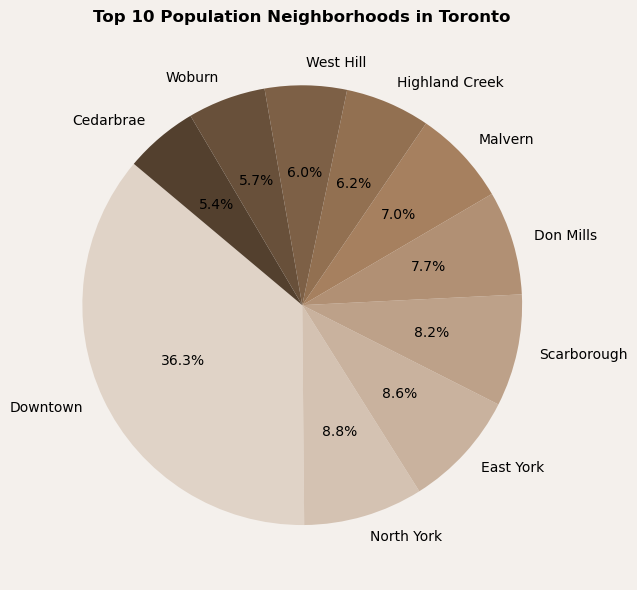

In [34]:
# Select the top 10 neighborhoods by population
toronto_income_p = toronto_data[['Postal Code', 'Neighborhood', 'Population']]
sorted_toronto_income_p = toronto_income_p.sort_values(by='Population', ascending=False)
t10_sorted_toronto_income_p = sorted_toronto_income_p.head(10)

# Applying coffee theme colors
colors = ['#E0D3C7', '#D4C2B2', '#C9B29E', '#BDA189', '#B19074', '#A6805F', '#927051', '#7D6046', '#68503A', '#53402E']

# Create a pie chart
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#F4F0EC')  # Set the background color
plt.pie(t10_sorted_toronto_income_p['Population'],
        labels=t10_sorted_toronto_income_p['Neighborhood'],
        colors=colors[:len(t10_sorted_toronto_income_p)],
        autopct='%1.1f%%',  # Show percentages
        startangle=140)  # Start angle for the pie chart

# Add a title
plt.title('Top 10 Population Neighborhoods in Toronto', fontsize=12, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()


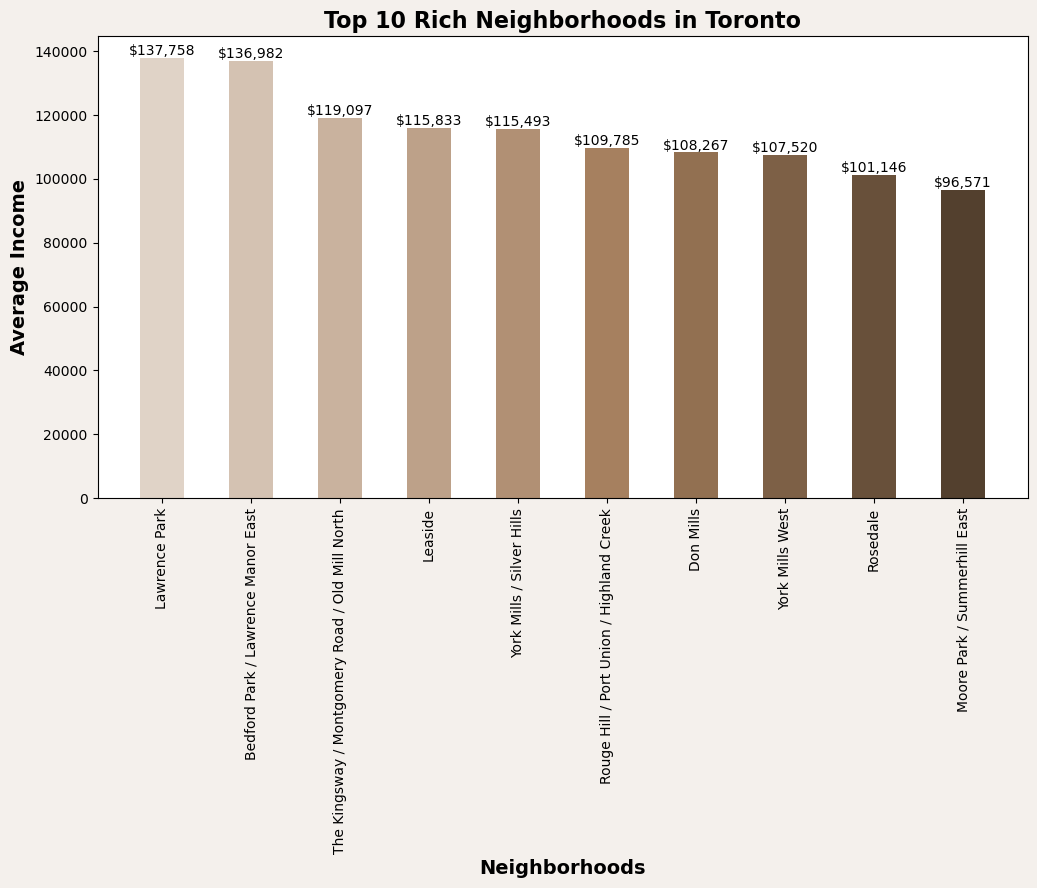

In [ ]:
# Plot the top income postal codes/Neighborhoods.
toronto_income_p = toronto_population_income[['Postal Code', 'Neighborhood','Average Income']]
toronto_income_p
sorted_toronto_income_p = toronto_income_p.sort_values(by='Average Income', ascending=False)
t20_sorted_toronto_income_p=sorted_toronto_income_p.head(10)
# I can see 4 postal code M5K, M5L, M5X and M7A	with null value
#colors = plt.cm.viridis(range(len(t20_sorted_toronto_income_p)))
colors = ['#E0D3C7', '#D4C2B2', '#C9B29E', '#BDA189', '#B19074', '#A6805F',
         '#927051', '#7D6046', '#68503A', '#53402E']

plt.figure(figsize=(12,6))
bars= plt.bar(t20_sorted_toronto_income_p['Postal Code'],
        t20_sorted_toronto_income_p['Average Income'],
        color=colors[:len(t20_sorted_toronto_income_p)])

for bar, income in zip(bars, t20_sorted_toronto_income_p['Average Income']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center text horizontally on bar
        bar.get_height() + 5000,  # Position text slightly above the bar
        f"${income:,.0f}",  # Format income as currency
        ha='center', 
        va='bottom', 
        fontsize=10
    )

#Add titles and labels
plt.title('Average Income by Postal Code in Toronto')
plt.xlabel('Postal Code')
plt.ylabel('Average Income')
plt.tight_layout()
plt.show()
